# Single Particle Model (SPM) 

## Model Equations

The SPM consists of two spherically symmetric diffusion equations: one within a representative negative particle ($\text{k}=\text{n}$) and one within a representative positive particle ($\text{k}=\text{p}$). In the centre of the particle the standard no-flux condition is imposed. Since the SPM assumes that all particles in an electrode behave in exactly the same way, the flux on the surface of a particle is simply the current $I$ divided by the thickness of the electrode $L_{\text{k}}$. The concentration of lithium in electrode $\text{k}$ is denoted $c_{\text{k}}$ and the current is denoted by $I$. The model equations for the SPM are then: 
\begin{align}
\frac{\partial c_{\text{s,k}}}{\partial t} &= -\frac{1}{r_{\text{k}}^2} \frac{\partial}{\partial r_{\text{k}}} \left(r_{\text{k}}^2 N_{\text{s,k}}\right), \\
N_{\text{s,k}} &= -D_{\text{s,k}}(c_{\text{s,k}}) \frac{\partial c_{\text{s,k}}}{\partial r_{\text{k}}}, \quad \text{k} \in \text{n, p}, \end{align}
$$
N_{\text{s,k}}\big|_{r_{\text{k}}=0} = 0, \quad \text{k} \in \text{n, p}, \quad \ \ - N_{\text{s,k}}\big|_{r_{\text{k}}=1} = 
\begin{cases}
		  \frac{I}{Fa_{\text{n}}L_{\text{n}}}, \quad &\text{k}=\text{n}, \\ 
		  -\frac{I}{Fa_{\text{p}}L_{\text{p}}}, \quad &\text{k}=\text{p}, 
\end{cases} \\
c_{\text{s,k}}(r_{\text{k}},0) = c_{\text{s,k,0}}, \quad \text{k} \in \text{n, p},$$
where $D_{\text{s,k}}$ is the diffusion coefficient in the solid, $N_{\text{s,k}}$ denotes the flux of lithium ions in the solid particle within the region $\text{k}$, and $r_{\text{k}} \in[0,1]$ is the radial coordinate of the particle in electrode $\text{k}$. 

### Voltage Expression
The voltage is obtained from the expression: 
$$
V = U_{\text{p}}(c_{\text{p}})\big|_{r_{\text{p}}=1} - U_{\text{n}}(c_{\text{n}})\big|_{r_{\text{n}}=1} - \frac{2RT}{F}\sinh^{-1}\left(\frac{I}{2j_{\text{0,p}} a_{\text{p}}L_{\text{p}}}\right) - \frac{2RT}{F}\sinh^{-1}\left(\frac{I}{2j_{\text{0,n}} a_{\text{p}}L_{\text{n}}}\right)
$$
with the exchange current densities given by
$$j_{\text{0,k}} =  (c_{\text{k}})^{1/2}(1-c_{\text{k}})^{1/2}  $$

More details can be found in [[3]](#References).

## Example solving SPM using PyBaMM

Below we show how to solve the Single Particle Model, using the default geometry, mesh, parameters, discretisation and solver provided with PyBaMM. In this notebook we explicitly handle all the stages of setting up, processing and solving the model in order to explain them in detail. However, it is often simpler in practice to use the `Simulation` class, which handles many of the stages automatically, as shown [here](../simulation-class.ipynb).

First we need to import `pybamm`, and then change our working directory to the root of the pybamm folder. 

In [21]:
%pip install pybamm -q    # install PyBaMM if it is not installed
import pybamm
import numpy as np
import os
import matplotlib.pyplot as plt
os.chdir(pybamm.__path__[0]+'/..')

Note: you may need to restart the kernel to use updated packages.


We then create an instance of the SPM:

In [22]:
model = pybamm.lithium_ion.SPM()

The model object is a subtype of [`pybamm.BaseModel`](https://pybamm.readthedocs.io/en/latest/source/api/models/base_models/base_model.html), and contains all the equations that define this particular model. For example, the `rhs` dict contained in `model` has a dictionary mapping variables such as $c_n$ to the equation representing its rate of change with time (i.e. $\partial{c_n}/\partial{t}$). We can see this explicitly by visualising this entry in the `rhs` dict:

In [23]:
variable = list(model.rhs.keys())[1]
equation = list(model.rhs.values())[1]
print('rhs equation for variable \'',variable,'\' is:')
path = 'examples/notebooks/models/'
equation.visualise(path+'spm1.png')

rhs equation for variable ' X-averaged negative particle concentration ' is:


![](spm1.png)

We need a geometry in which to define our model equations. In pybamm this is represented by the [`pybamm.Geometry`](https://pybamm.readthedocs.io/en/latest/source/api/geometry/index.html) class. In this case we use the default geometry object defined by the model

In [24]:
geometry = model.default_geometry

This geometry object defines a number of domains, each with its own name, spatial variables and min/max limits (the latter are represented as equations similar to the rhs equation shown above). For instance, the SPM has the following domains:

In [25]:
print('SPM domains:')
for i, (k, v) in enumerate(geometry.items()):
    print(str(i+1)+'.',k,'with variables:')
    for var, rng in v.items():
        if 'min' in rng:
            print('  -(',rng['min'],') <=',var,'<= (',rng['max'],')')
        else:
            print(var, '=', rng['position'])

SPM domains:
1. negative electrode with variables:
  -( 0 ) <= x_n <= ( Negative electrode thickness [m] / (Negative electrode thickness [m] + Separator thickness [m] + Positive electrode thickness [m]) )
2. separator with variables:
  -( Negative electrode thickness [m] / (Negative electrode thickness [m] + Separator thickness [m] + Positive electrode thickness [m]) ) <= x_s <= ( Negative electrode thickness [m] / (Negative electrode thickness [m] + Separator thickness [m] + Positive electrode thickness [m]) + Separator thickness [m] / (Negative electrode thickness [m] + Separator thickness [m] + Positive electrode thickness [m]) )
3. positive electrode with variables:
  -( Negative electrode thickness [m] / (Negative electrode thickness [m] + Separator thickness [m] + Positive electrode thickness [m]) + Separator thickness [m] / (Negative electrode thickness [m] + Separator thickness [m] + Positive electrode thickness [m]) ) <= x_p <= ( 1 )
4. negative particle with variables:
  -( 0

Both the model equations and the geometry include parameters, such as $L_p$. We can substitute these symbolic parameters in the model with values by using the [`pybamm.ParameterValues`](https://pybamm.readthedocs.io/en/latest/source/api/parameters/parameter_values.html) class, which takes either a python dictionary or CSV file with the mapping between parameter names and values. Rather than create our own instance of `pybamm.ParameterValues`, we will use the default parameter set included in the model

In [26]:
param = model.default_parameter_values

We can then apply this parameter set to the model and geometry

In [27]:
param.process_model(model)
param.process_geometry(geometry)

The next step is to mesh the input geometry. We can do this using the [`pybamm.Mesh`](https://pybamm.readthedocs.io/en/latest/source/api/meshes/index.html) class. This class takes in the geometry of the problem, and also two dictionaries containing the type of mesh to use within each domain of the geometry (i.e. within the positive or negative electrode domains), and the number of mesh points. 

The default mesh types and the default number of points to use in each variable for the SPM are:

In [28]:
for k, t in model.default_submesh_types.items():
    print(k,'is of type',t.__name__)
for var, npts in model.default_var_pts.items():
    print(var,'has',npts,'mesh points')

negative electrode is of type Uniform1DSubMesh
separator is of type Uniform1DSubMesh
positive electrode is of type Uniform1DSubMesh
negative particle is of type Uniform1DSubMesh
positive particle is of type Uniform1DSubMesh
negative particle size is of type Uniform1DSubMesh
positive particle size is of type Uniform1DSubMesh
current collector is of type SubMesh0D
x_n has 20 mesh points
x_s has 20 mesh points
x_p has 20 mesh points
r_n has 20 mesh points
r_p has 20 mesh points
y has 10 mesh points
z has 10 mesh points
R_n has 30 mesh points
R_p has 30 mesh points


With these defaults, we can then create our mesh of the given geometry:

In [29]:
mesh = pybamm.Mesh(geometry, model.default_submesh_types, model.default_var_pts)

The next step is to discretise the model equations using this mesh. We do this using the [`pybamm.Discretisation`](https://pybamm.readthedocs.io/en/latest/source/api/spatial_methods/discretisation.html) class, which takes both the mesh we have already created, and a dictionary of spatial methods to use for each geometry domain. For the case of the SPM, we use the following defaults for the spatial discretisation methods:

In [30]:
for k, method in model.default_spatial_methods.items():
    print(k,'is discretised using',method.__class__.__name__,'method')

macroscale is discretised using FiniteVolume method
negative particle is discretised using FiniteVolume method
positive particle is discretised using FiniteVolume method
negative particle size is discretised using FiniteVolume method
positive particle size is discretised using FiniteVolume method
current collector is discretised using ZeroDimensionalSpatialMethod method


We then create the `pybamm.Discretisation` object, and use this to discretise the model equations

In [31]:
disc = pybamm.Discretisation(mesh, model.default_spatial_methods)
disc.process_model(model);

After this stage, all of the variables in `model` have been discretised into `pybamm.StateVector` objects, and spatial operators have been replaced by matrix-vector multiplications, ready to be evaluated within a time-stepping algorithm of a given solver. For example, the rhs expression for $\partial{c_n}/\partial{t}$ that we visualised above is now represented by:

In [32]:
model.concatenated_rhs.children[1].visualise(path+'spm2.png')

![](spm2.png)

Now we are ready to run the time-stepping routine to solve the model. Once again we use the default ODE solver.

In [33]:
# Solve the model at the given time points (in seconds)
solver = model.default_solver
n = 250
t_eval = np.linspace(0, 3600, n)
print('Solving using',type(solver).__name__,'solver...')
solution = solver.solve(model, t_eval)
print('Finished.')

Solving using CasadiSolver solver...
Finished.


Each model in pybamm has a list of relevant variables defined in the model, for use in visualising the model solution or for comparison with other models. The SPM defines the following variables:

In [34]:
print('SPM model variables:')
for v in model.variables.keys():
    print('\t-',v)

SPM model variables:
	- Time
	- Time [s]
	- Time [min]
	- Time [h]
	- x
	- x [m]
	- x_n
	- x_n [m]
	- x_s
	- x_s [m]
	- x_p
	- x_p [m]
	- Sum of electrolyte reaction source terms
	- Sum of positive electrode electrolyte reaction source terms
	- Sum of x-averaged positive electrode electrolyte reaction source terms
	- Sum of interfacial current densities
	- Sum of positive electrode interfacial current densities
	- Sum of x-averaged positive electrode interfacial current densities
	- Sum of negative electrode electrolyte reaction source terms
	- Sum of x-averaged negative electrode electrolyte reaction source terms
	- Sum of negative electrode interfacial current densities
	- Sum of x-averaged negative electrode interfacial current densities
	- r_p
	- r_p [m]
	- r_n
	- r_n [m]
	- Current density variable
	- Total current density
	- Total current density [A.m-2]
	- Current [A]
	- C-rate
	- Discharge capacity [A.h]
	- Porosity
	- Separator porosity
	- Positive electrode porosity
	- X-aver

To help visualise the results, pybamm provides the `pybamm.ProcessedVariable` class, which takes the output of a solver and a variable, and allows the user to evaluate the value of that variable at any given time or $x$ value. These processed variables are automatically created by the solution dictionary.

In [35]:
voltage = solution['Voltage [V]']
c_s_n_surf = solution['Negative particle surface concentration']
c_s_p_surf = solution['Positive particle surface concentration']

One we have these variables in hand, we can begin generating plots using a library such as Matplotlib. Below we plot the voltage and surface particle concentrations versus time

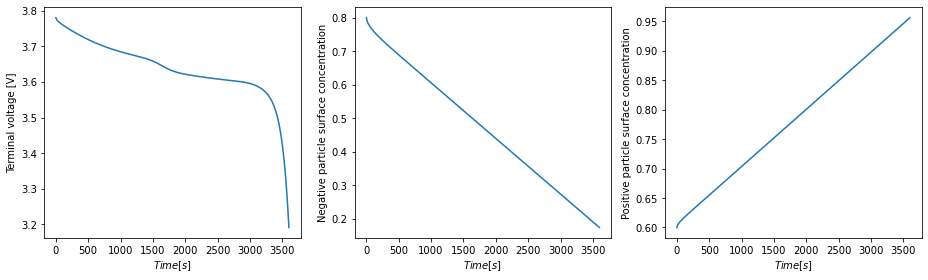

In [36]:
t = solution["Time [s]"].entries
x = solution["x [m]"].entries[:, 0]
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(13,4))

ax1.plot(t, voltage(t))
ax1.set_xlabel(r'$Time [s]$')
ax1.set_ylabel('Voltage [V]')

ax2.plot(t, c_s_n_surf(t=t, x=x[0]))  # can evaluate at arbitrary x (single representative particle)
ax2.set_xlabel(r'$Time [s]$')
ax2.set_ylabel('Negative particle surface concentration')

ax3.plot(t, c_s_p_surf(t=t, x=x[-1]))  # can evaluate at arbitrary x (single representative particle)
ax3.set_xlabel(r'$Time [s]$')
ax3.set_ylabel('Positive particle surface concentration')

plt.tight_layout()
plt.show()

Some of the output variables are defined over space as well as time. Once option to visualise these variables is to use the `interact` slider widget. Below we plot the negative/positive particle concentration over $r$, using a slider to change the current time point

In [37]:
c_s_n = solution['Negative particle concentration']
c_s_p = solution['Positive particle concentration']
r_n = solution["r_n [m]"].entries[:, 0]
r_p = solution["r_p [m]"].entries[:, 0]

In [38]:
c_s_n = solution['Negative particle concentration']
c_s_p = solution['Positive particle concentration']
r_n = solution["r_n [m]"].entries[:, 0, 0]
r_p = solution["r_p [m]"].entries[:, 0, 0]

def plot_concentrations(t):
    f, (ax1, ax2) = plt.subplots(1, 2 ,figsize=(10,5))
    plot_c_n, = ax1.plot(r_n, c_s_n(r=r_n,t=t,x=x[0]))  # can evaluate at arbitrary x (single representative particle)
    plot_c_p, = ax2.plot(r_p, c_s_p(r=r_p,t=t,x=x[-1]))  # can evaluate at arbitrary x (single representative particle)
    ax1.set_ylabel('Negative particle concentration')
    ax2.set_ylabel('Positive particle concentration')
    ax1.set_xlabel(r'$r_n$ [m]')
    ax2.set_xlabel(r'$r_p$ [m]')
    ax1.set_ylim(0, 1)
    ax2.set_ylim(0, 1)
    plt.show()
    
import ipywidgets as widgets
widgets.interact(plot_concentrations, t=widgets.FloatSlider(min=0,max=3600,step=10,value=0));


interactive(children=(FloatSlider(value=0.0, description='t', max=3600.0, step=10.0), Output()), _dom_classes=…

The QuickPlot class can be used to plot the common set of useful outputs which should give you a good initial overview of the model. The method `Quickplot.dynamic_plot` employs the slider widget.  

In [39]:
quick_plot = pybamm.QuickPlot(solution)
quick_plot.dynamic_plot();

interactive(children=(FloatSlider(value=0.0, description='t', max=1.0, step=0.01), Output()), _dom_classes=('w…

## References

The relevant papers for this notebook are:

In [40]:
pybamm.print_citations()

[1] Joel A. E. Andersson, Joris Gillis, Greg Horn, James B. Rawlings, and Moritz Diehl. CasADi – A software framework for nonlinear optimization and optimal control. Mathematical Programming Computation, 11(1):1–36, 2019. doi:10.1007/s12532-018-0139-4.
[2] Charles R. Harris, K. Jarrod Millman, Stéfan J. van der Walt, Ralf Gommers, Pauli Virtanen, David Cournapeau, Eric Wieser, Julian Taylor, Sebastian Berg, Nathaniel J. Smith, and others. Array programming with NumPy. Nature, 585(7825):357–362, 2020. doi:10.1038/s41586-020-2649-2.
[3] Scott G. Marquis, Valentin Sulzer, Robert Timms, Colin P. Please, and S. Jon Chapman. An asymptotic derivation of a single particle model with electrolyte. Journal of The Electrochemical Society, 166(15):A3693–A3706, 2019. doi:10.1149/2.0341915jes.
[4] Valentin Sulzer, Scott G. Marquis, Robert Timms, Martin Robinson, and S. Jon Chapman. Python Battery Mathematical Modelling (PyBaMM). Journal of Open Research Software, 9(1):14, 2021. doi:10.5334/jors.309.
